In [1]:
import sys
sys.path.append(r'/Users/richardkoehler/Documents/GitHub/icn/icn_onset')
import preprocessing_RK
import normalization_RK
import os
import numpy as np
import pandas as pd
from scipy import stats, signal
import mne
#from bids import BIDSLayout
import mne_bids
#import settings
import json
#from coordinates_io import BIDS_coord
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score, confusion_matrix, average_precision_score, auc, precision_recall_curve, \
                            plot_precision_recall_curve
import multiprocessing
from pybv import write_brainvision
import matplotlib.pyplot as plt

#select file in bids format
raw = mne_bids.read.io.brainvision.read_raw_brainvision('/Users/richardkoehler/Documents/Neurology_Data/\
MovementPrediction/test/rawdata/sub-01/eeg/sub-01_task-Selfpaced_Rotation_Off_eeg.vhdr')

#load data
raw.load_data()

#set channeltypes
chan_type_set = { 'ECOG_L{:02}'.format(n) : 'ecog' for n in range(1, 7) }
chan_type_set.update({'LFP_STNR{:1}'.format(n) : 'ecog' for n in range(1, 9) })
chan_type_set.update({'LFP_STNL{:1}'.format(n) : 'ecog' for n in range(1, 9) })
chan_type_set.update({ 'AUX 3-1' : 'misc' })
raw.set_channel_types(mapping=chan_type_set)

#rereference and rename ECoG channels
raw_ecog_reref = raw.copy().pick(['ECOG_L{:02}'.format(n) for n in range(1, 7)])\
                                               .set_eeg_reference(ref_channels='average', projection=False)
channel_renaming_dict = {name: name + '_reref' for name in raw_ecog_reref.ch_names}
raw_ecog_reref.rename_channels(channel_renaming_dict)

#rereference LFP_STNL8 against LFP_STNL1 and rename
raw_lfp_reref = raw.copy().pick(['LFP_STNL1', 'LFP_STNL8']).set_eeg_reference(ref_channels=['LFP_STNL1'], \
                                                                              projection=False)
channel_renaming_dict = {name: name + '_reref' for name in raw_lfp_reref.ch_names}
raw_lfp_reref.rename_channels(channel_renaming_dict)

#add rereferenced ECoG channels to raw
raw.add_channels([raw_ecog_reref], force_update_info=False)

#add rereferenced LFP_STNL8 channel to raw
raw.add_channels([raw_lfp_reref.pick(['LFP_STNL8_reref'])], force_update_info=False)

#rename rotation channel
raw.rename_channels({'AUX 3-1' : 'ROTA'})

#extract and reorder relevant channels
relev_chans = ['ECOG_L01_reref', 'ECOG_L02_reref', 'ECOG_L03_reref', 'ECOG_L04_reref', 
               'ECOG_L05_reref', 'ECOG_L06_reref', 'LFP_STNR8', 'LFP_STNL8_reref', 'ROTA']
raw.reorder_channels(relev_chans)

#crop artefacts at end and beginning of recording after visual inspection
tmin = 15.69
tmax = 513.17
crop_raw = raw.copy().crop(tmin=tmin, tmax=tmax, include_tmax=True)

#write data into brainvision file for further analyses
crop_data = crop_raw.get_data()
write_brainvision(crop_data, 4096, relev_chans, 'crop_relevchan_reref_sub-01_task-Selfpaced_Rotation_Off_eeg', \
                  '/Users/richardkoehler/Documents/Neurology_Data/MovementPrediction/test/derivatives/mne-p/', \
                  events=None, resolution=1e-07, unit='uV', scale_data=False, fmt='binary_float32', meas_date=None)


#read events from csv file in case of import from MatLab
matlab = False
if matlab is True:
    events = pd.read_csv('/Users/richardkoehler/Documents/Neurology_Data/MovementPrediction/test/derivatives/spm12/\
    sub-01/preproc/events.csv', sep=',',header=None)

    #reindex events according to crop
    tmin_ind = raw.time_as_index(tmin, use_rounding=False)
    tmax_ind = raw.time_as_index(tmax, use_rounding=False)
    reind_events = events.copy()
    reind_events[0] = reind_events[0]-tmin_ind

    #plot reindexed events against cropped data for plausability
    ind_events = np.array(reind_events)[:,0]
    Y = np.array(crop_data)[8,ind_events]
    X = np.array(reind_events)[:,0]
    plt.plot(X, Y, 'bo')
    plt.plot(crop_data[8,:])

    #write reindexed events to csv
    reind_events.to_csv(r'/Users/richardkoehler/Documents/Neurology_Data/MovementPrediction/test/derivatives/mne-p/reind_events.csv', index=False, header=False)

#epoch Data
epoch = False
if epoch is True:
    epochs = mne.Epochs(crop_raw, events, event_id=1, tmin=-5, tmax=5)
    #plot for plausability check
    epochs.average('ROTA').plot()

#morlet wave decomposition
morlet = False
if morlet == True:
    freqs = np.arange(2., 200., 1.)
    n_cycles = 7
    picks = ['ECOG_L04_reref']
    power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, picks=picks)
    #plot for plausability
    power.plot('ECOG_L04_reref', baseline=(-4., -3.), mode='zscore', tmin=-2, tmax=2)

Extracting parameters from /Users/richardkoehler/Documents/Neurology_Data/MovementPrediction/test/rawdata/sub-01/eeg/sub-01_task-Selfpaced_Rotation_Off_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 2111339  =      0.000 ...   515.464 secs...
ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ECoG reference.
ECoG channel type selected for re-referencing
Applying a custom ECoG reference.


In [2]:
# Get recropped data, preprocess using modified script by TM
vhdr_file = '/Users/richardkoehler/Documents/Neurology_Data/MovementPrediction/test/derivatives/mne-p/crop_relevchan_reref_sub-01_task-Selfpaced_Rotation_Off_eeg.vhdr'
xf_zs, ml_zs, xf_zs_r, ml_zs_r = preprocessing_RK.write_out_raw(vhdr_file, test_LM=False, resampling=True, write_json=False)

Extracting parameters from /Users/richardkoehler/Documents/Neurology_Data/MovementPrediction/test/derivatives/mne-p/crop_relevchan_reref_sub-01_task-Selfpaced_Rotation_Off_eeg.vhdr...
Setting channel info structure...
Num of samples to be cropped (due to running_var) from events array in case of MatLab import:  4095


>>Signal decimation is being done
>>baseline_als is being used
id_event:  (98,)
time_event:  (98,)
Number of detected events:  49.0


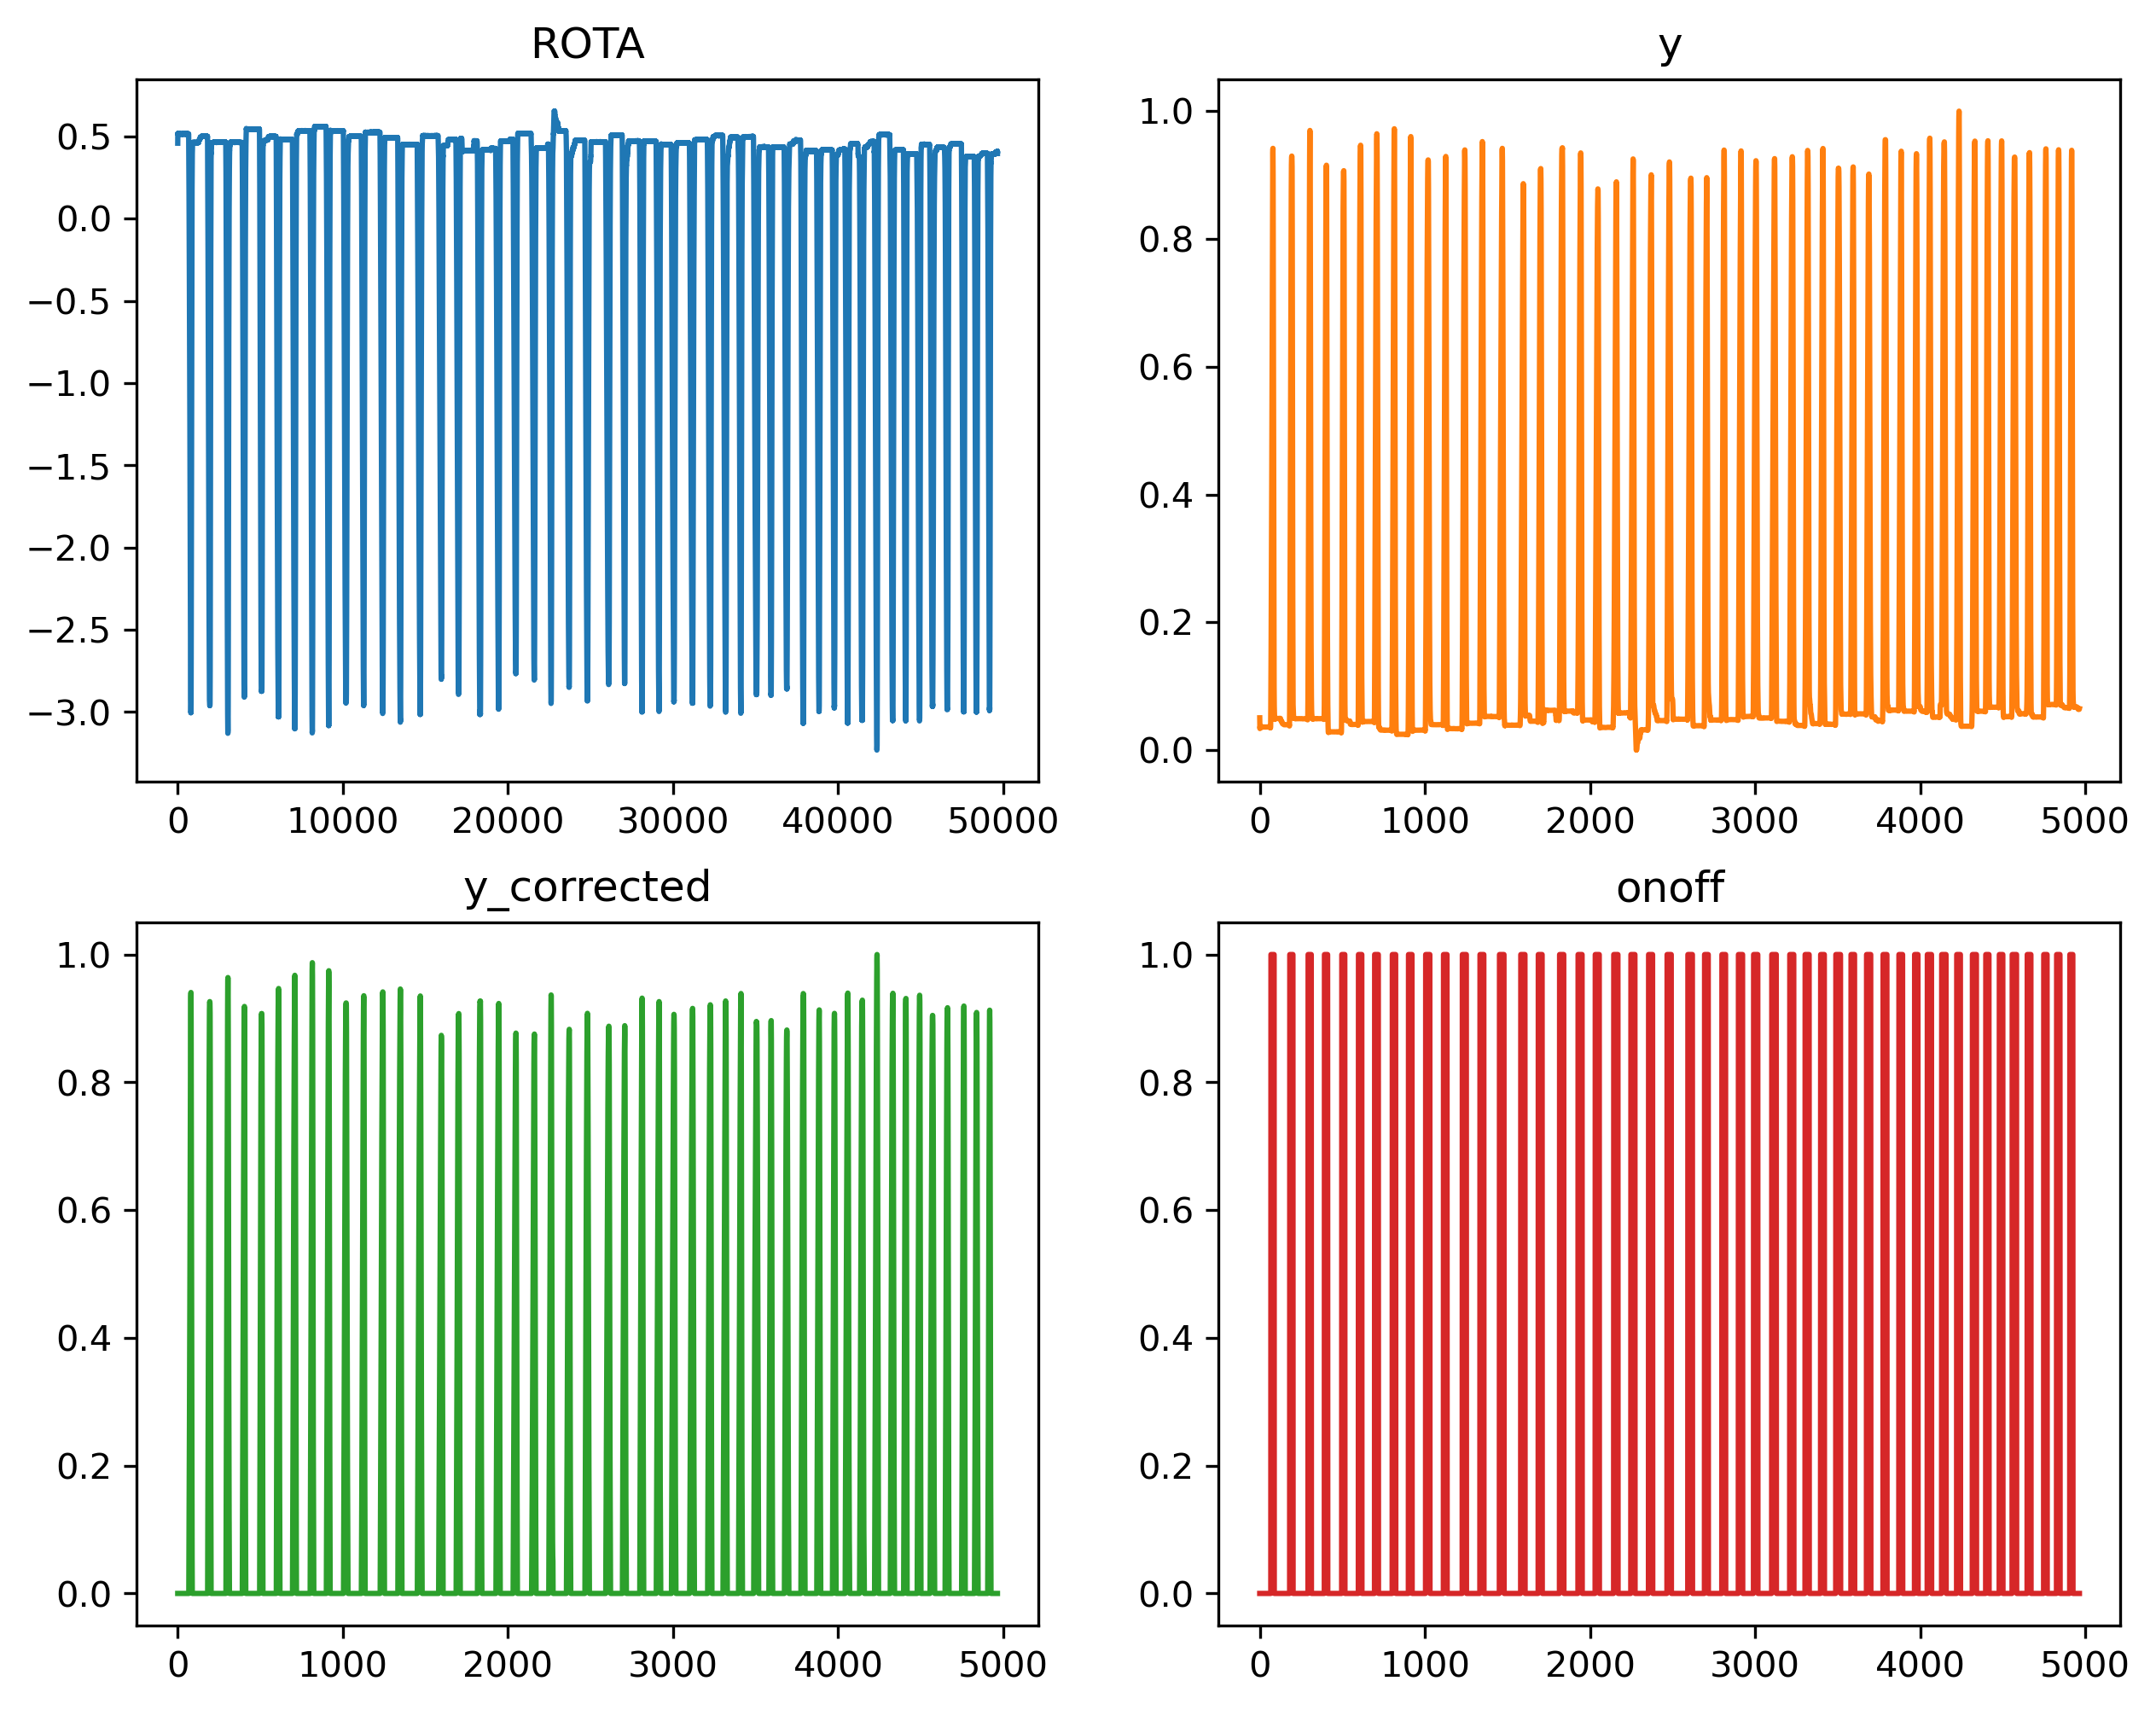

In [3]:
# Create class labels using VPs normalization script (RK mod)
# Do baseline correction
mov = ml_zs_r[0,:].T*-1
y_corrected, onoff, y = normalization_RK.baseline_correction(mov, method='baseline_als', param=[1e2, 1e-4], thr=0.5e-1, normalize=True, \
                                            Decimate=10, Verbose=True)

# Create array of events
events_arr = normalization_RK.create_events_array(onoff, ml_zs[0,:], 1)
print('Number of detected events: ', len(events_arr[:,0])/2)

# Plot, evaluate, tweak param+thr in baseline_correction and rerun
fig, axs = plt.subplots(2, 2, figsize=(10,8),dpi =300)
axs[0, 0].plot(ml_zs_r[0,:])
axs[0, 0].set_title('ROTA')
axs[0, 1].plot(y, 'tab:orange')
axs[0, 1].set_title('y')
axs[1, 0].plot(y_corrected, 'tab:green')
axs[1, 0].set_title('y_corrected')
axs[1, 1].plot(onoff, 'tab:red')
axs[1, 1].set_title('onoff')
plt.show()

Rolling Window = 4096, No Shuffle, Average all channels
(8, 8, 2029600)


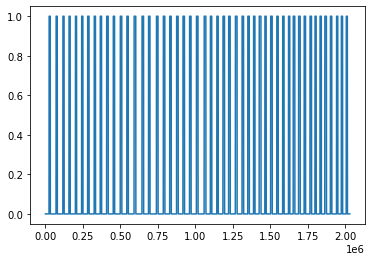

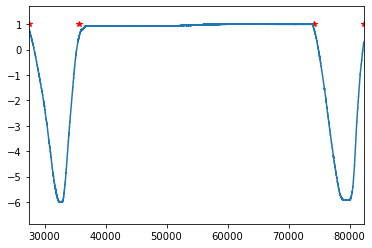

Coefficients: 
 [[-136.81062087   37.15266037   17.84441089   -2.95921369  -48.09912299
   333.09522643 2007.56665347 -346.36035397]]
Confusion Matrix (tn, tp, fn, fp):  (282409, 67531, 42027, 13953)
Accuracy:  0.862091052424123
F1:  0.7069754294867098
Average precision-recall score: 0.86
AUCPR:  0.863421387896296
Ratio:  0.26990047299960584
AUCPR_min:  0.1490543546954709
AUCNPR:  0.8394978423623914


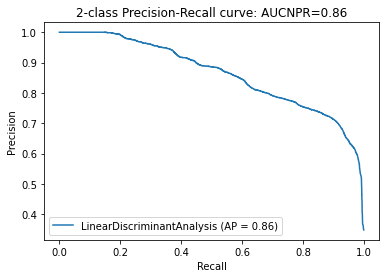

In [4]:
# Run LDA
#import events
#events2 = pd.read_csv('/Users/richardkoehler/Documents/Neurology_Data/MovementPrediction/test/derivatives/mne-p/reind_events.csv', sep=',',header=None)
#events2[0] = events2[0]-(2037680-2033585)-3400

sfreq = 4096
#howmanyseconds is movement?
#secs = 2.5
#fr_sec = int(sfreq*secs)

print('Rolling Window = 4096, No Shuffle, Average all channels')

Average = True
if Average == True:
# Average over all channels
    # Exclude border artefacts
    X = xf_zs[:,:,3400:2033000]
    cor_ev = events_arr[:,0]-3399
    print(X.shape)
    # Now average
    Xm = np.mean(X, axis=1)
    Xm = Xm.T
    
    # Add class labels from event array
    y = np.zeros_like(X[0][0])
    for i in np.arange(0,len(events_arr),2):
        for s in np.arange(cor_ev[i], cor_ev[i+1]):
            y[s] = 1
        i=i+2

    # Plot for plausability
    plt.plot(y)
    plt.show()

    # Plot for accuracy
    #plt.figure(dpi=600, figsize=(7,5))
    plt.plot(events_arr[:,0], events_arr[:,1], 'r*')
    plt.plot(ml_zs[0,:]*2)
    plt.xlim(events_arr[0][0],events_arr[3][0])
    plt.show()

#Split samples in test and train set
    test_size = 0.2
    X_train, X_test, y_train, y_test = train_test_split(Xm, y, test_size=test_size, shuffle=False)

# Create LDA object
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

# Train the model using the training sets
    lda.fit(X_train, y_train)

# Make predictions using the testing set
    y_pred = lda.predict(X_test)
    y_pred_all = lda.predict(Xm)
   
    # The coefficients
    print('Coefficients: \n', lda.coef_)
    
    
    #Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Confusion Matrix (tn, tp, fn, fp): ', (tn, tp, fn, fp))
    
    # The accuracy
    print('Accuracy: ', lda.score(X_test, y_test))

    # The F1 Score
    print('F1: ', f1_score(y_test, y_pred))
    #metrics.plot_roc_curve(lda, X_test, y_test)
    


    Plot_LDA = False
    if Plot_LDA == True:
        #print(range(0, len(y_pred)))
        plt.figure(figsize=(20,5))
        plt.xlabel('Samples')
        plt.ylabel('Prediction')
        plt.plot(range(0, len(y_pred2)), y_pred2[:]*0.9, 'r*')
        plt.plot(range(0, len(y_pred2)), y, 'b*')
        #plt.figure(figsize=(20,10))
        plt.show()

    PlotPR = True
    if PlotPR == True:
        y_score = lda.decision_function(X_test)
        ap = average_precision_score(y_test, y_score)
        print('Average precision-recall score: {0:0.2f}'.format(ap))
        precision, recall, thresh = precision_recall_curve(y_test, y_score)
        aucpr = auc(recall,precision)
        print('AUCPR: ', aucpr)
        # For AUCNPR see: arXiv:1206.4667v2
        ratio = sum((tp,fn)) / sum((tn, tp, fn, fp))
        print('Ratio: ',ratio)
        aucpr_min = 1 + (1-ratio)*np.log(1-ratio)/ratio
        #AUCPR_max is 1 for AUCPR over recall in [0,1]
        aucpr_max = 1
        print('AUCPR_min: ', aucpr_min)
        aucnpr = (aucpr-aucpr_min)/(aucpr_max-aucpr_min)
        print('AUCNPR: ', aucnpr)
        disp = plot_precision_recall_curve(lda, X_test, y_test)
        disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AUCNPR={0:0.2f}'.format(ap))
        plt.show()


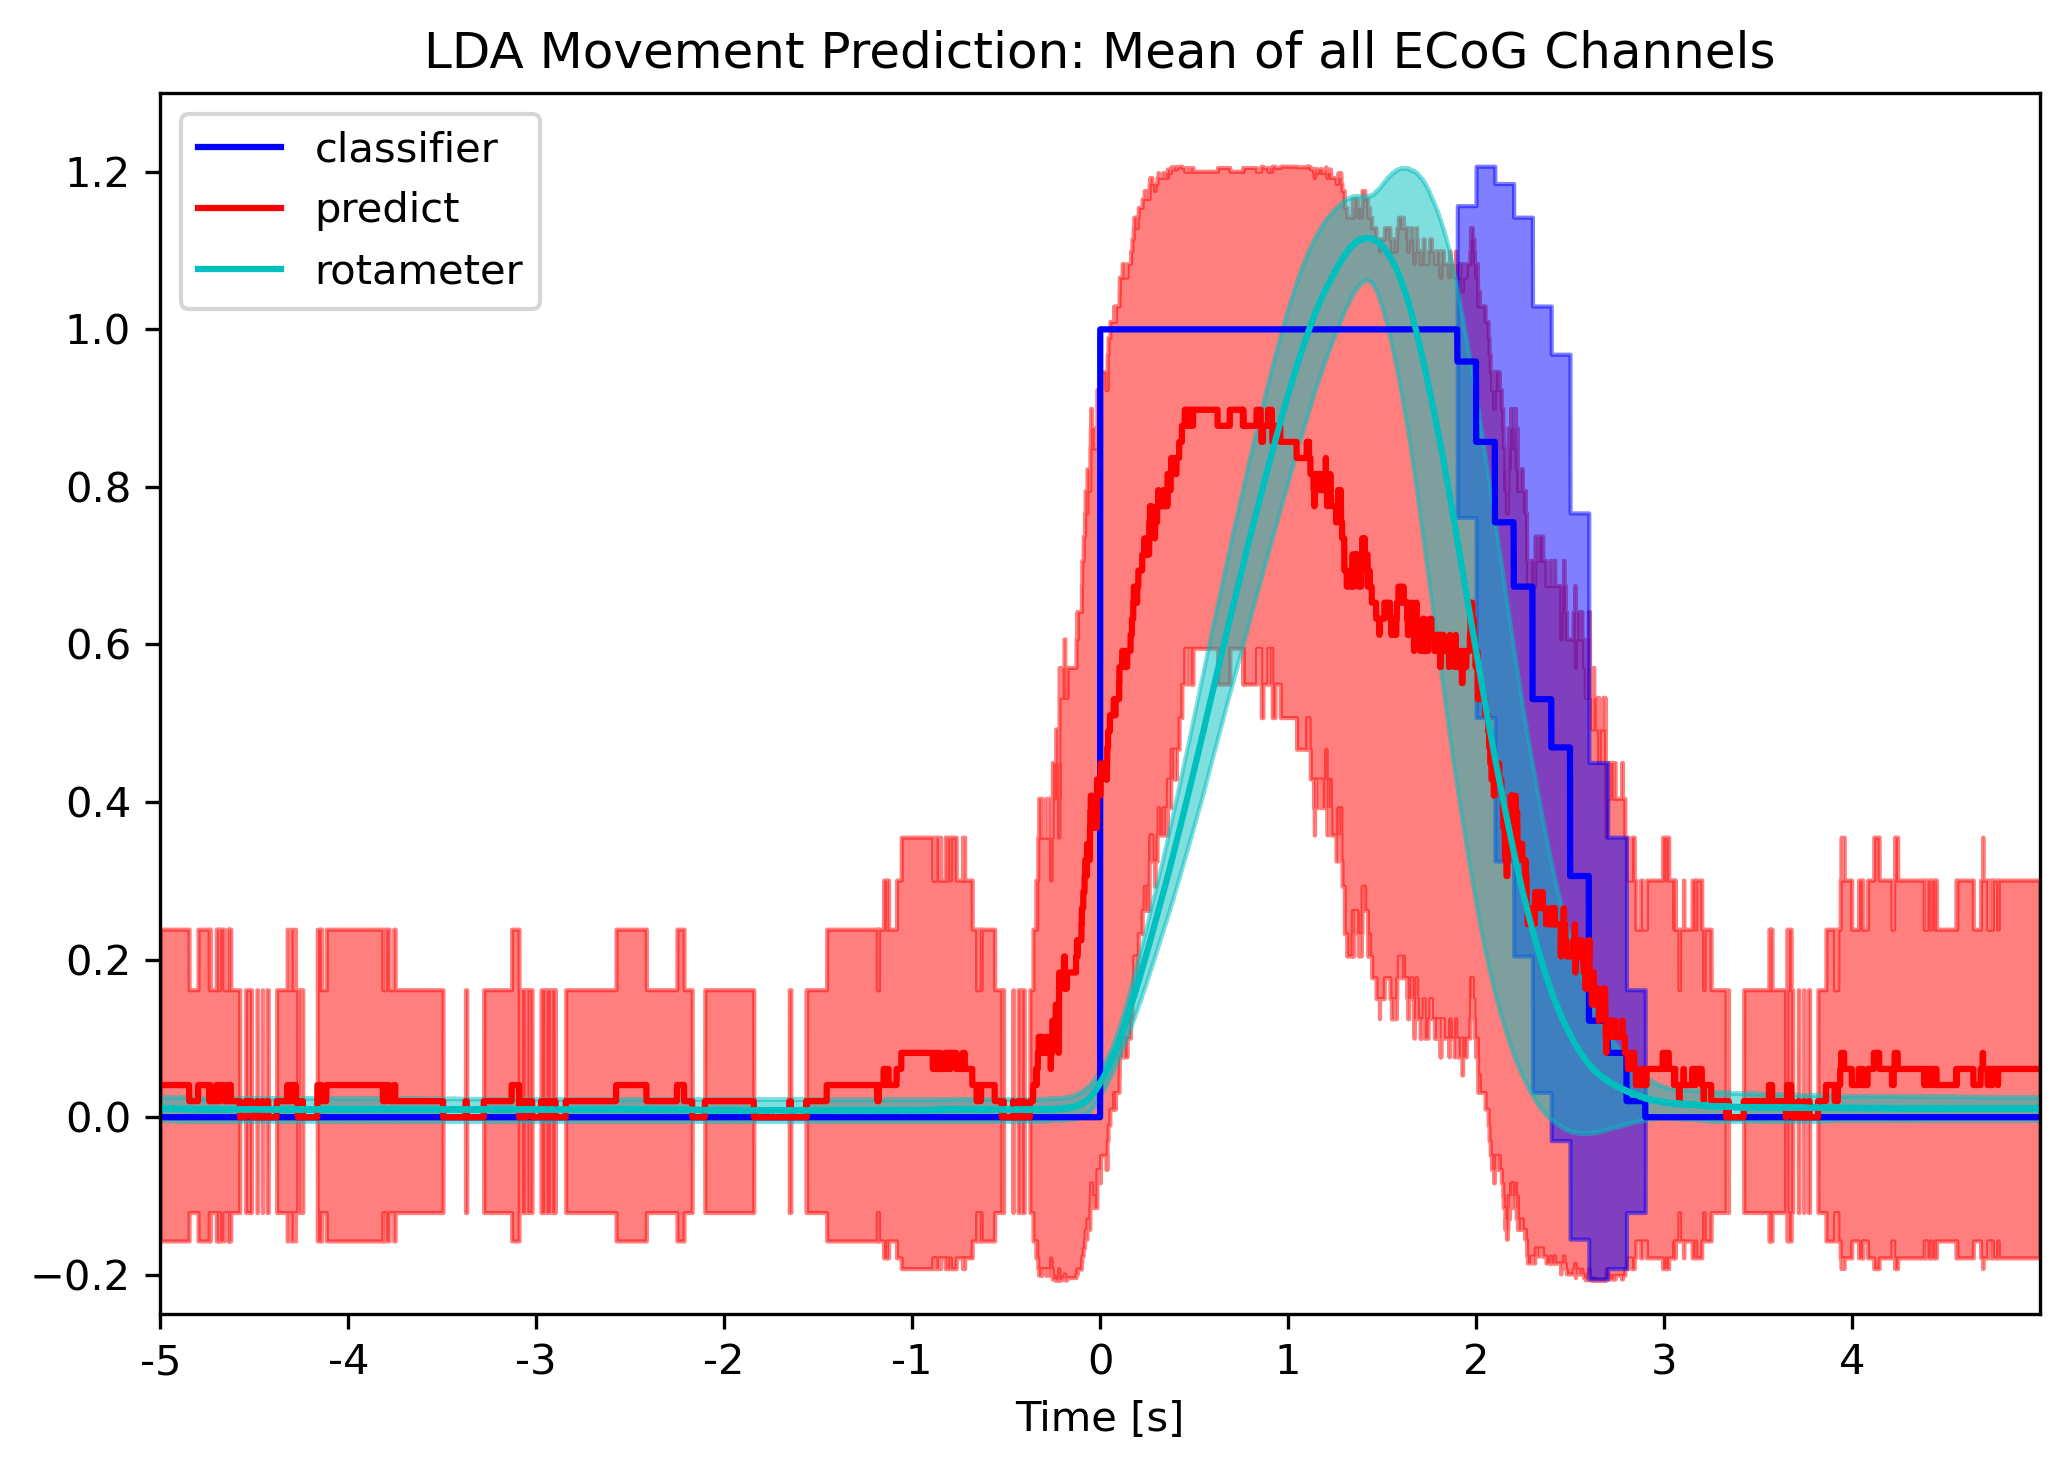

In [6]:
# Create and plot epochs
def plot_mov_epochs(epoch_pr, epoch_true, mov_true, epoch_lim = 5):

    #xlab = np.arange(-epoch_lim, epoch_lim, 1)
    xlab = np.round(np.arange(-epoch_lim, epoch_lim, 1),2)
    plt.title('LDA Movement Prediction: Mean of all ECoG Channels')
    plt.plot(epoch_true.mean(axis=0), color='b',label='classifier')
    plt.plot(epoch_pr.mean(axis=0), color='r',label='predict')
    plt.plot(mov_true.mean(axis=0), color='c',label='rotameter')
    #plt.errorbar(np.arange(epoch_pr.shape[1]), epoch_pr.mean(axis=0), epoch_pr.std(axis=0), \
      #          label='predict', alpha=0.5, color='r')
    #plt.errorbar(np.arange(epoch_true.shape[1]), epoch_true.mean(axis=0), epoch_true.std(axis=0), \
     #            label='true', alpha=0.5, color='b')
    plt.fill_between(np.arange(epoch_pr.shape[1]), epoch_pr.mean(axis=0)-epoch_pr.std(axis=0), \
                epoch_pr.mean(axis=0)+epoch_pr.std(axis=0), alpha=0.5, color='r')
    plt.fill_between(np.arange(epoch_true.shape[1]), epoch_true.mean(axis=0)-epoch_true.std(axis=0), \
                epoch_true.mean(axis=0)+epoch_true.std(axis=0), alpha=0.5, color='b')
    plt.fill_between(np.arange(mov_true.shape[1]), mov_true.mean(axis=0)-mov_true.std(axis=0), \
                mov_true.mean(axis=0)+mov_true.std(axis=0), alpha=0.5, color='c')
    

    plt.xticks(np.arange(0,(epoch_lim*2/1)*raw.info['sfreq'], raw.info['sfreq']), xlab)
    plt.xlabel('Time [s]')
    plt.ylim(-0.25, 1.3)
    plt.legend(loc='upper left')
    plt.xlim(0*raw.info['sfreq'], 10*raw.info['sfreq'])


# Sampling frequency
fs_ep = raw.info['sfreq']
# Epoch length in sec
l_ep = 10
# Calculate sampling corrected time factor for plotting
fac = int(fs_ep*l_ep/2)

# y value correction for plotting
M = (ml_zs[0][3400:]-0.5)*-0.33

# Epoch data

pred_concat = np.empty((fac*2))
true_concat = np.empty((fac*2))
mov_concat = np.empty((fac*2))
#print(pred_concat.shape)

for i in np.arange(0,len(cor_ev),2):
    pred = y_pred_all[(cor_ev[i]-fac):(cor_ev[i]+fac)]
    #pred = y_pred_all[(cor_ev[i]-fac):(cor_ev[i]+fac)]
    pred_concat = np.vstack((pred_concat, pred)) 
    true = y[(cor_ev[i]-fac):(cor_ev[i]+fac)]
    true_concat = np.vstack((true_concat, true))
    mov = M[(cor_ev[i]-fac):(cor_ev[i]+fac)]
    mov_concat = np.vstack((mov_concat, mov))
    i=i+2

# Temporary bugfix
pred_concat = pred_concat[1:]
true_concat = true_concat[1:]
mov_concat = mov_concat[1:]

# Now plot
num_ep = len(pred_concat)
plot_all = True
if plot_all is True:
    p_a = 1
else:
    p_a = test_size
ep_min = int(num_ep-p_a*num_ep)
plt.figure(dpi=300, figsize=(7,5))
plot_mov_epochs(pred_concat[ep_min:], true_concat[ep_min:], mov_concat[ep_min:])
plt.tight_layout()